In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

/home/deepank/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
t = list(tf.python_io.tf_record_iterator('Data/eval_subset_latest_4.tfrecord'))
tf_example = tf.train.Example.FromString(t[0])
tf_example.features.feature['video_id'].bytes_list.value[0].decode()

'-0CamVQdP_Y'

In [3]:
len(t)

1010

In [4]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    print('rec_len',rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size
#     print('num_batches',num_batches)
    j = 0

    subset_labels = [4,13,53,69,70,71,112,113,318,326,327,344,348,351,352,500]
    ## merging classes to create 5 major classes
    crowd =  [4, 13, 53, 69, 70, 71]
    birds = [112, 113]
    vehicles_passing = [318,326,344,348,351,352]
    ambient_traffic = [327]
    silence = [500]
    
    while True:
        X = []
        y = []
        
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
    
            label_no = next(x for x in example_label if x in subset_labels)

            if label_no in crowd:
                y.append(0)
            if label_no in birds:
                y.append(1)
            if label_no in vehicles_passing:
                y.append(2)
            if label_no in ambient_traffic:
                y.append(3)
            if label_no in silence:
                y.append(4)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
#             print('n_frames',n_frames)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
#             print('pad', pad)
            audio_frame += pad
#             print('audio_frame', audio_frame)
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
#         print("****************************************************************************")
#         print(X.shape,len(y))
        yield X, np.array(y)

In [5]:
import itertools
batch_size = 1
val_gen = data_generator(batch_size,'Data/eval_subset_latest_4.tfrecord')

val = list(itertools.islice(val_gen,1009//1))
# print(val)
X = [d[0] for d in val]
y = [d[1] for d in val]
X = np.concatenate(X)
y = np.concatenate(y)

rec_len 1010


In [6]:
from keras.models import load_model
m1 = load_model('Data/Trained_model_LSTM_2.h5')

In [7]:
p1 = m1.predict(X)

In [8]:
print(p1.shape)

(1009, 5)


In [9]:
y_pred = [np.argmax(p) for p in p1]

In [11]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y))

             precision    recall  f1-score   support

          0       0.88      0.82      0.85       402
          1       0.63      0.86      0.73       124
          2       0.88      0.91      0.89       330
          3       0.86      0.95      0.90        58
          4       0.86      0.53      0.65        95

avg / total       0.84      0.83      0.83      1009



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
for ix in range(5):
    print(ix, confusion_matrix(y,y_pred)[ix].sum())
cm = confusion_matrix(y,y_pred)
print(cm)
cm_acc = cm.diagonal()/cm.sum(axis=1)
cm_acc_sum = np.sum(cm_acc)
print(cm_acc)
print(cm_acc_sum/5)

0 377
1 169
2 341
3 64
4 58
[[331   9  13   0  24]
 [ 39 107  11   0  12]
 [ 25   6 299   3   8]
 [  2   1   5  55   1]
 [  5   1   2   0  50]]
[0.87798408 0.63313609 0.87683284 0.859375   0.86206897]
0.8218793979294429


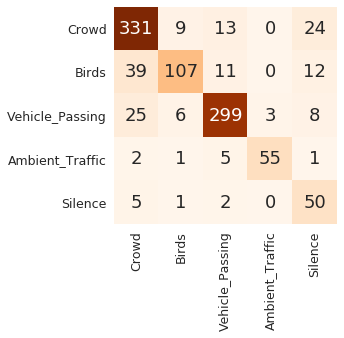

In [13]:
import seaborn as sn
import pandas as pd

cols = ['Crowd', 'Birds', 'Vehicle_Passing', 'Ambient_Traffic', 'Silence']
rws = ['Crowd', 'Birds', 'Vehicle_Passing', 'Ambient_Traffic', 'Silence']

df_cm = pd.DataFrame(cm, columns = cols, index = rws)
plt.figure(figsize = (4,4))
sn.set(font_scale=1.25)#for label size
# sn.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
# sn.set_style({'axes.axisbelow': False})
sn.heatmap(df_cm.astype(int), annot=True,annot_kws={"size": 18}, fmt='g', cmap = "Oranges", cbar = False)# font size
plt.show()

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score

a = accuracy_score(y, y_pred)
b = cohen_kappa_score(y, y_pred)
print(a,b)

0.8344895936570862 0.7672028504363659
